In [ ]:
pip install yfinance

In [1]:
from cvxpy_portfolio_optimizer.objective_function import (
    TrackingErrorObjectiveFunction,
    WorstRealizationObjectiveFunction,
)
from cvxpy_portfolio_optimizer.constraint_function import (
    SumToOneConstraint,
    NoShortSellConstraint,
    TrackingErrorConstraint,
)
from cvxpy_portfolio_optimizer.portfolio_optimization_problem import PortfolioOptimizationProblem
import cvxpy as cp
import yfinance as yf

In [2]:
tickers = ["TSLA", "MSFT", "IBM", "GOOG", "AAPL", "AMZN", "ADBE", "EXC", "XOM", "META"]
rets = (
    yf.download(tickers, period="1y")["Adj Close"].loc[:, tickers].pct_change().iloc[1:, :].ffill()
)
rets

[*********************100%%**********************]  10 of 10 completed


Ticker,TSLA,MSFT,IBM,GOOG,AAPL,AMZN,ADBE,EXC,XOM,META
Date,,,,,,,,,,
2023-05-23,-0.016413,-0.018432,0.005333,-0.020497,-0.015155,-0.000174,-0.004381,0.007976,0.013623,-0.006363
2023-05-24,-0.015449,-0.004473,-0.019504,-0.013383,0.001632,0.015306,-0.012580,-0.007171,0.011184,0.010011
2023-05-25,0.008584,0.038458,0.008593,0.022279,0.006692,-0.014989,0.071905,-0.015940,-0.017938,0.013964
2023-05-26,0.047162,0.021386,0.016803,0.008685,0.014105,0.044435,0.059506,-0.003037,-0.006530,0.037002
2023-05-30,0.041363,-0.005047,0.004578,-0.006298,0.010660,0.012905,0.004381,-0.001269,-0.008860,0.001832
...,...,...,...,...,...,...,...,...,...,...
2024-05-14,0.032928,0.006865,-0.001194,0.006027,0.006173,0.002680,-0.014821,0.007081,0.006070,0.008205
2024-05-15,-0.020051,0.017484,0.005378,0.011342,0.012218,-0.005773,0.019750,0.008594,0.007734,0.020536
2024-05-16,0.004885,-0.004940,0.004220,0.008914,0.000632,-0.012689,-0.005089,-0.002840,-0.005988,-0.017257


In the following portfolio optimization problem we will:
- Minimize Tracking Error on a universe of 10 assets with respect to a benchmark, (bench_rets) in this case the SP500 etf

In [3]:
bench_rets = yf.download(["SPY"], period="1y")["Adj Close"].pct_change().iloc[1:].ffill()
bench_rets

[*********************100%%**********************]  1 of 1 completed


Date
2023-05-23   -0.011223
2023-05-24   -0.007245
2023-05-25    0.008660
2023-05-26    0.012951
2023-05-30    0.000381
                ...   
2024-05-14    0.004588
2024-05-15    0.012383
2024-05-16   -0.002058
2024-05-17    0.001438
2024-05-20    0.003759
Name: Adj Close, Length: 250, dtype: float64

In [4]:
pop = PortfolioOptimizationProblem(
    returns=rets,
    objective_functions=[
        TrackingErrorObjectiveFunction(benchmark_returns=bench_rets),
    ],
    constraint_functions=[
        SumToOneConstraint(),
        NoShortSellConstraint(),
    ],
)
ptf = pop.solve(solver=cp.CLARABEL)

In [5]:
ptf.weights

TSLA    0.045739
MSFT    0.179718
IBM     0.144582
GOOG    0.071033
AAPL    0.149741
AMZN    0.079072
ADBE    0.011560
EXC     0.125275
XOM     0.161779
META    0.031501
dtype: float64

<Axes: xlabel='Date'>

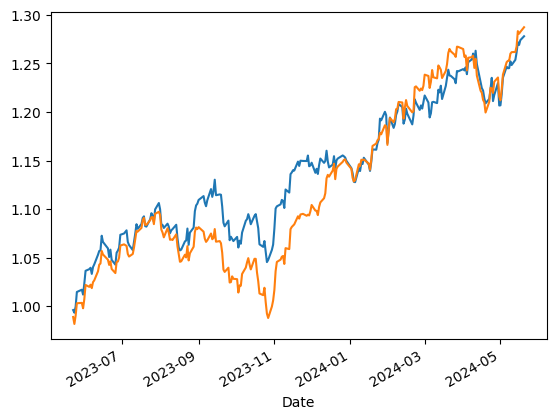

In [6]:
ptf.portfolio_timeseries().plot()
(1 + bench_rets).cumprod().plot()

In [7]:
# Tracking error
ptf_rets = rets.dot(ptf.weights)
(ptf_rets - bench_rets).std()

0.003475703452823504

Tracking error can also be a constraint, and we can minimize another objective function

In [8]:
pop = PortfolioOptimizationProblem(
    returns=rets,
    objective_functions=[WorstRealizationObjectiveFunction()],
    constraint_functions=[
        SumToOneConstraint(),
        NoShortSellConstraint(),
        TrackingErrorConstraint(benchmark_returns=bench_rets, upper_bound=0.005),
    ],
)
ptf = pop.solve(solver=cp.CLARABEL)

In [9]:
# Tracking error
ptf_rets = rets.dot(ptf.weights)
(ptf_rets - bench_rets).std()

0.004988204726798182

<Axes: >

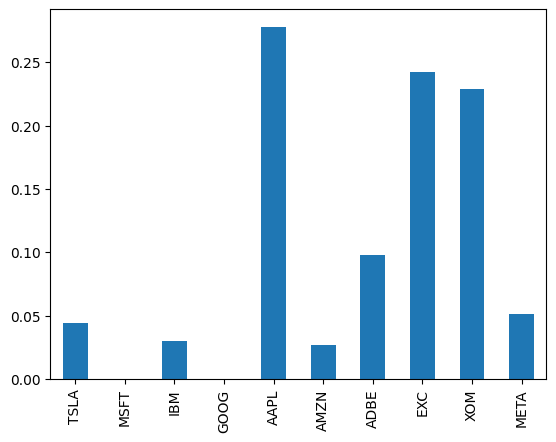

In [10]:
ptf.weights.plot.bar()